<a href="https://colab.research.google.com/github/chogh824/machine-learning/blob/main/5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 교차 검증과 그리드 서치

## 교차 검증

테스트 성능을 사용해 계속 성능을 확인하다 보면 점점 테스트 세트에 맞춰가게 됨

테스트 세트로 일반화 성능을 올바르게 예측하려면 가능한 한 테스트 세트를 사용하지 말아야 함.

모델을 만들고 나서 마지막에 딱 한 번만 사용하는 것이 좋음


테스트 세트를 사용하지 않으면 모델이 과대적합인지 과소적합인지 판단하기 어려움. 테스트 세트를 사용하지 않고 이를 측정하는 간단한 방법 -> 훈련 세트를 또 나누는 것! 이를 **검증 세트** 라고 함

전체 80 훈련 세트, 거기의 25%를 검증 세트, 나머지를 테스트 세트 이런 식으로 구성을 함.

훈련 세트에서는 모델을 훈련 - 검증 세트에서는 모델을 평가 -> 테스트하고 싶은 매개변수를 바꿔가며 가장 좋은 모델을 고름.

그 후 이 매개변수를 사용해 훈련 세트와 검증 세트를 합쳐 전체 훈련 데이터에서 모델을 다시 훈련. 마지막에 테스트 세트에서 최종 점수를 평가.

In [2]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')    # 데이터를 읽음

In [3]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()     # class 열을 타깃으로 사용하고 나머지 열은 특성 배열에 저장

In [4]:
from sklearn.model_selection import train_test_split      # 훈련 세트와 테스트 세트를 나눔

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [5]:
sub_input, val_input, sub_target, val_target = train_test_split(    #여기서 또 훈련 세트와 검증 세트를 나눔
    train_input, train_target, test_size=0.2, random_state=42)

In [6]:
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [7]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


훈련 세트와 검증 세트의 평가 점수를 이용하여 최적화

최적화 완료 후 테스트 세트로 모델을 최종 평가



In [8]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_input, train_target)

print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

0.8454877814123533
0.8415384615384616


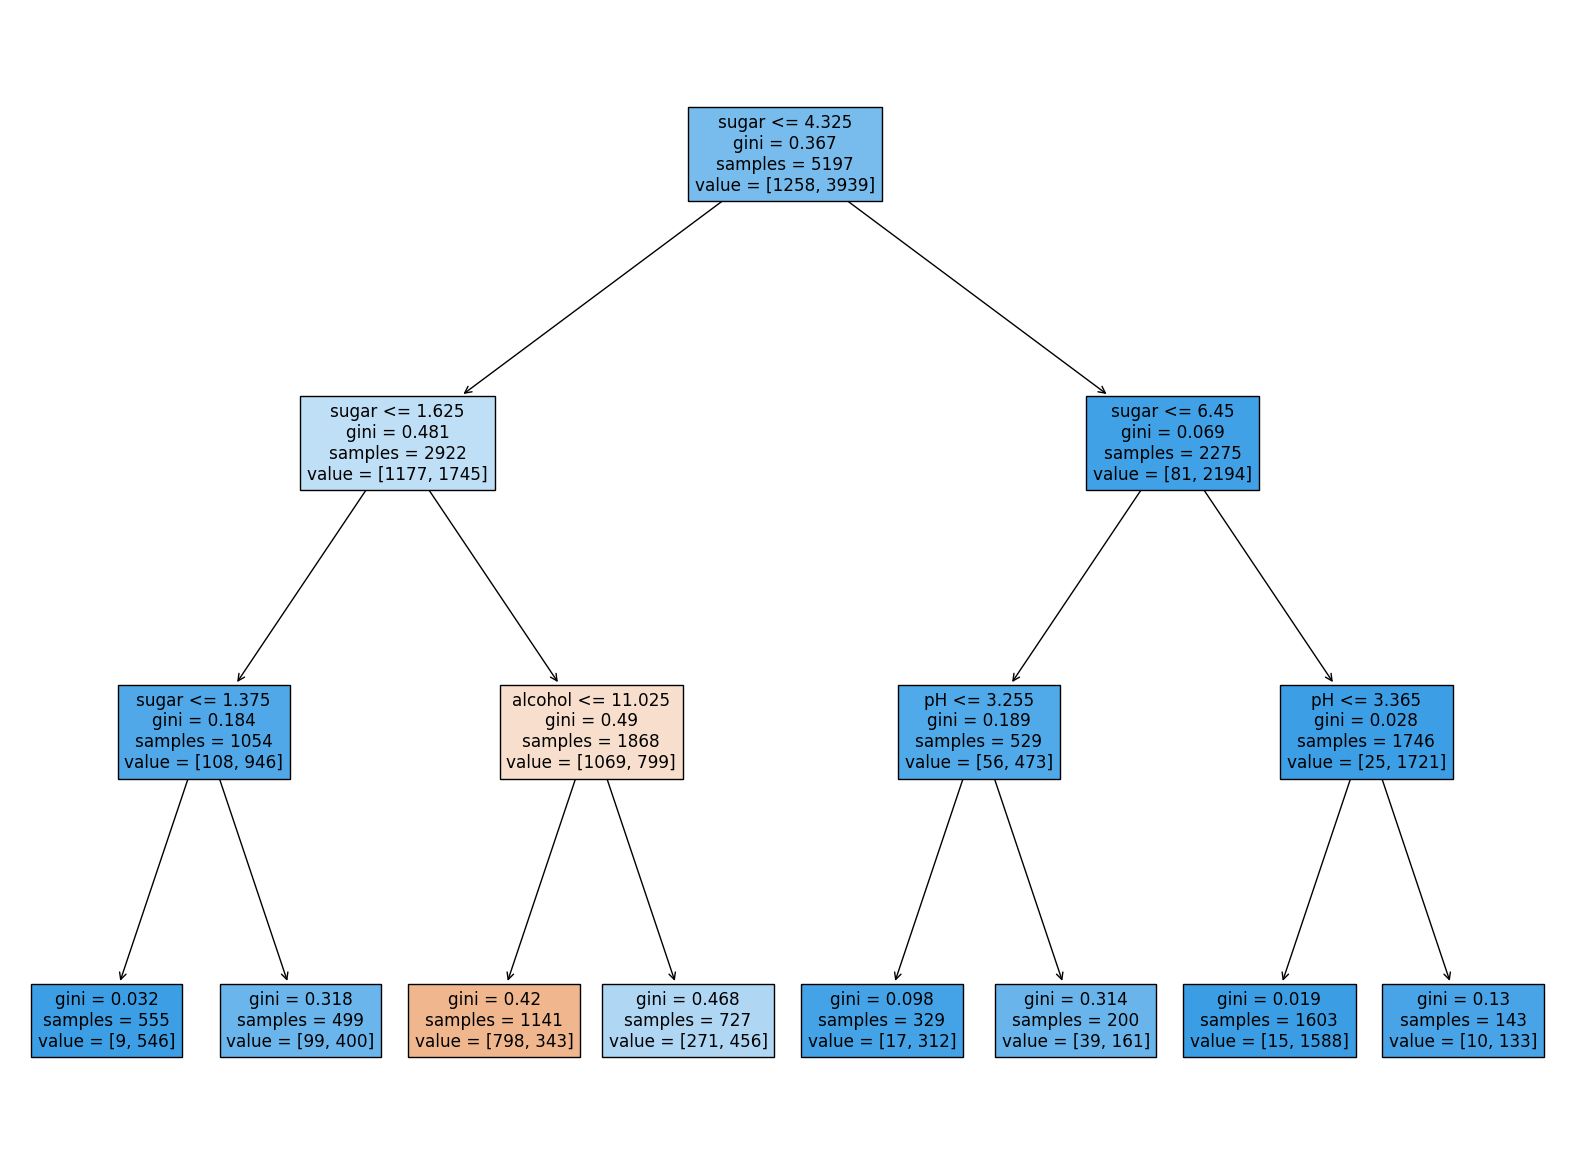

In [9]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

In [10]:
dt = DecisionTreeClassifier(min_impurity_decrease=0.0005, random_state=42)
dt.fit(train_input, train_target)

print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

0.8874350586877044
0.8615384615384616


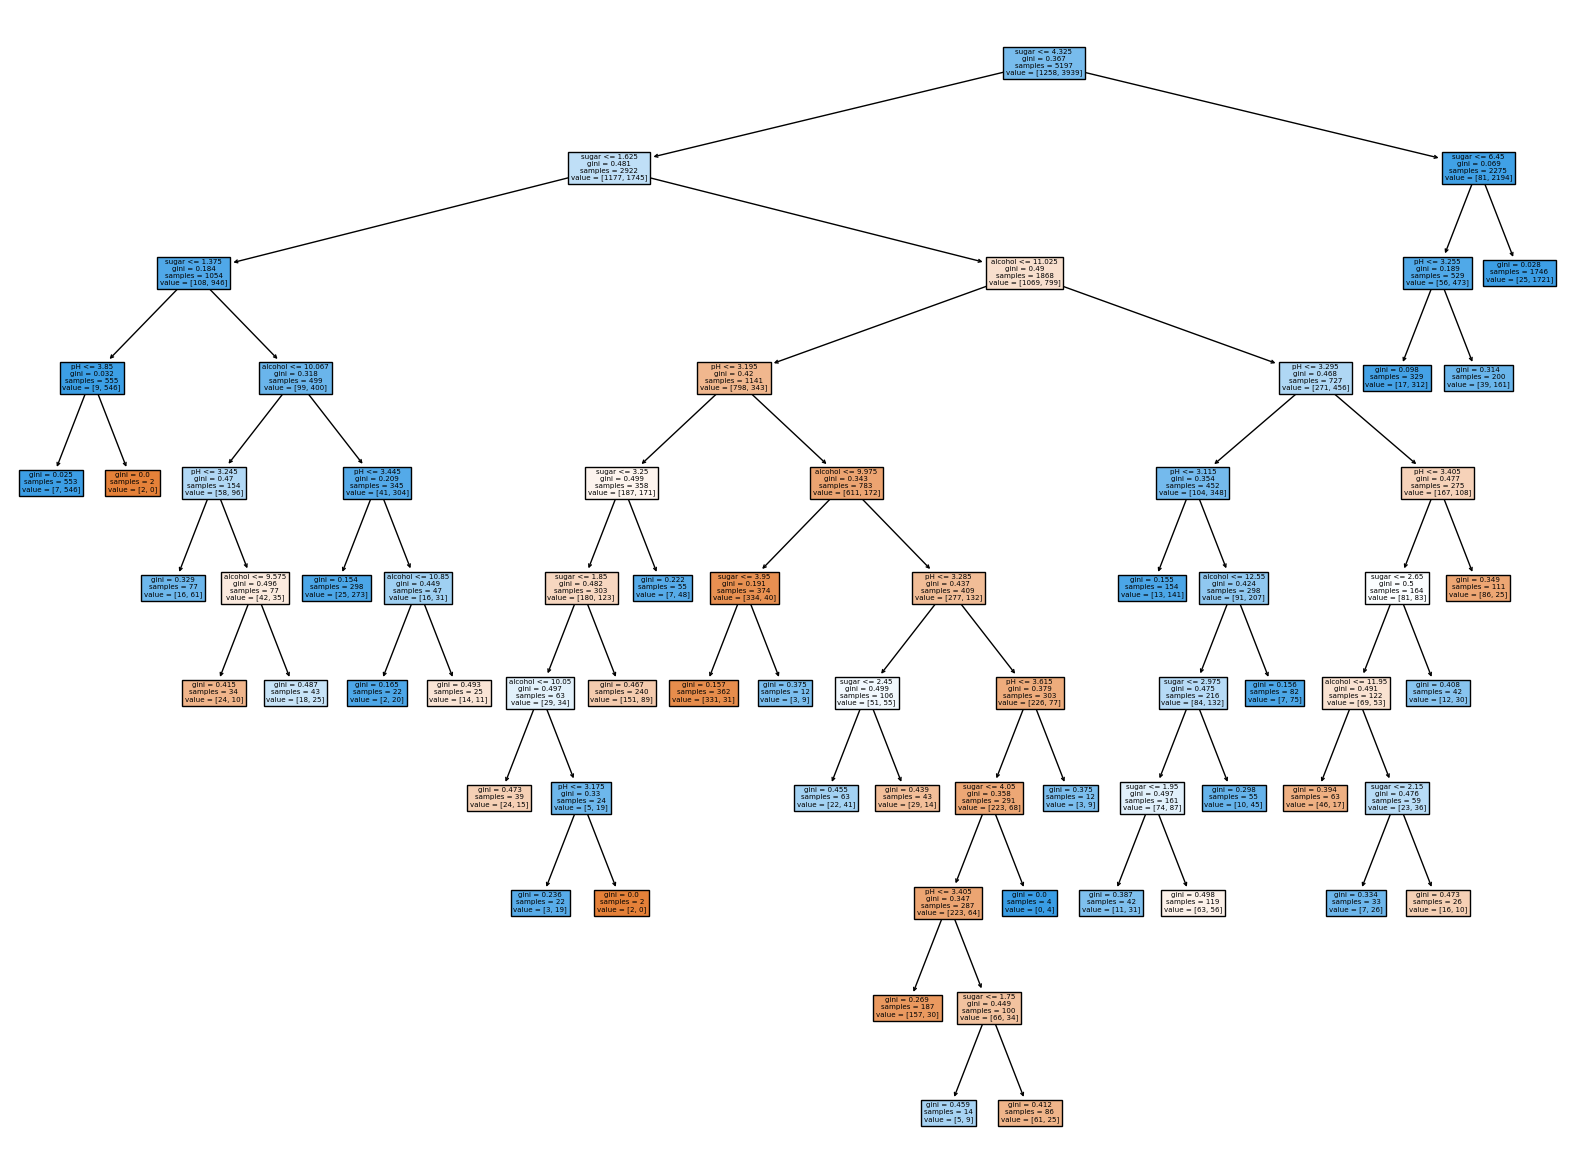

In [11]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

## 교차 검증

검증 세트를 떼어 내어 평가하는 과정을 여러번 반복

서로 다른 검증 세트로 지정하고, 검증을 n번 반복하고 이를 평균 내서 점수를 구하는 것을 N-폴드 교차 검증이라고 함

In [12]:
from sklearn.model_selection import cross_validate

scores = cross_validate(dt, train_input, train_target)  #cross_validate()라는 교차 검증 함수를 사용
print(scores)

{'fit_time': array([0.00488472, 0.00400996, 0.00452375, 0.00387335, 0.00379753]), 'score_time': array([0.00084209, 0.00103617, 0.00061369, 0.00056434, 0.00064683]), 'test_score': array([0.86538462, 0.86923077, 0.8825794 , 0.84985563, 0.87102984])}


In [13]:
import numpy as np

print(np.mean(scores['test_score']))

0.8676160509365515


### 주의할 점

cross_validate()는 훈련 세트를 섞어 폴드를 나누지 않음

만약 train_test_split()를 하지 않았다면 분할기를 지정해야함

cross_validate()는 회귀 모델일 경우 KFold 분할기를 사용하고 분류 모델일 경우 StratifiedKFold를 사용

섞지 않는 것이 디폴트이므로 따로 설정해줘야 함

In [14]:
from sklearn.model_selection import StratifiedKFold

scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.8676160509365515


훈련 세트를 먼저 섞은 후 10-폴드 교차검증을 수행

In [15]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  # n_splits 매개변수는 몇 폴드 교차검증을 할지 정함
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8597261745961168


## **하이퍼파라미터 튜닝**

하이퍼파라미터: 모델이 학습할 수 없어서 사용자가 지정해야만 하는 파라미터

예를 들어, 결정 트리 모델에서는 (max_depth와 min_samples_split,min_inpurity_decrease 등)

반대로 모델이 학습하는 파라미터는 모델 파라미터

예를 들어, 결정 트리 모델에서는 분할변수와 분할점

튜닝 작업은 기본값을 그대로 사용해서 모델을 훈련한 후, 검증 세트의 점수나 교차 검증을 통해서 매개변수를 조금씩 바꿔감

문제는 한 매개변수의 최적값을 찾고 다른 매개변수의 최적값을 찾으면 안됨

모든 매개변수를 동시에 바꿔가면서 최적의 값을 찾아야 함

예를 들어, 결정 트리 모델에서 최적의 max_depth와 min_impurity_decrease 동시에 찾아야 함

매개변수가 많아질수록 최적의 값들을 찾는 것이 복잡함

## **그리드 서치(grid search)**

하이퍼파라미터 탐색과 교차 검증을 한 번에 수행

즉, cross_validate()함수를 호출할 필요가 없음


In [16]:
from sklearn.model_selection import GridSearchCV

params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [17]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

In [18]:
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

GridSearchCV의 cv 매개변수 기본값은 5이므로 params에서 설정한 5개의 min_impurity_decrease 별로 결정 트리를 5번 실행

즉, 25번의 결정 트리 모델을 훈련

n_jobs: 병렬 실행에서 사용할 CPU 코어 수이며, -1이면 모든 코어를 사용함

In [19]:
dt = gs.best_estimator_   # 검증 점수가 가장 높은 모델을 best_estimator_ 속성에 저장시켜놓음
print(dt.score(train_input, train_target))

0.9615162593804117


In [20]:
print(gs.best_params_)  # 최적의 매개변수는 best_params_ 속성에 저장되어 있음

{'min_impurity_decrease': 0.0001}


In [21]:
print(gs.cv_results_['mean_test_score']) # 5번의 교차 검증으로 얻은 점수 출력

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [22]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


**그리드 서치를 이용한 최적화 과정 정리**

  1. 탐색할 매개변수를 지정

  2. 훈련 세트에서 그리드 서치를 수행하여 최상의 평균 검증 점수가 나오는 매개변수 조합 찾음

    - 이 조합은 그리드 서치 객체에 저장

  3. 그리드 서치는 최상의 매개변수에서 (교차 검증에 사용한 훈련 세트가 아님) 전체 훈련 세트를 사용해 최종 모델 훈련. 이 모델 또한 그리드 서치 객체에 저장!



  

In [23]:
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }

In [24]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [25]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


최상의 교차 검증 점수 확인

In [26]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


찾은 파라미터로 모델을 생성하고 테스트 점수 확인

**랜덤 서치(random search)**

매개변수의 값이 수치일 때 값의 범위나 간격을 미리 정하기 어려울 수 있음

너무 많은 매개변수 조건이 있어 그리드 서치 수행 시간이 오래 걸릴 수 있음

이럴 때 랜덤 서치를 사용하면 좋음

매개변수 값의 목록이 아닌 매개변수를 샘플링 할 수 있는 확률 분포 객체를 전달함

**싸이파이 scipy**

파이선의 핵심 과학 라이브러리 중 하나

적분, 보간, 선형 대수, 확률 등을 포함한 수치 계산 전용 라이브러리

---

stats 서브 패키지 사용

통계학(statistics)과 관련된 패키지


---
uniform과 randint 클래스

주어진 범위에서 고르게 값을 뽑음 -> 균등 분포에서 샘필링한다라고 함

randint는 정수값을 uniform은 실수값을 선택

rvs: random variates




In [27]:
from scipy.stats import uniform, randint

In [28]:
rgen = randint(0, 10)
rgen.rvs(10)  # 0에서 10 사이에 랜덤한 값 10개 뽑아보기

array([8, 0, 2, 8, 4, 5, 5, 5, 1, 3])

10번의 샘플링을 했기 때문에 고르게 샘플링되는 것 같아 보이지 않음

그러나 샘플링 숫자를 늘리면 쉽게 확인 가능

1000번 샘플링해서 각 숫자의 개수를 확인

In [29]:
np.unique(rgen.rvs(1000), return_counts=True) # 카운트 하면서 1000번 뽑기

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 99,  98,  86,  91, 114, 100, 107,  89,  92, 124]))

In [30]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.81821248, 0.68616239, 0.31621544, 0.40546164, 0.33331793,
       0.67193002, 0.57707472, 0.23900431, 0.63109783, 0.03382362])

In [31]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

In [32]:
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb37f14f700>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb37f104c10>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb37f14e9e0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb37f14efb0>},
                   random_state=42)

In [33]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [34]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


최적의 모델은 이미 전체 훈련 세트(train_input, train_target)로 훈련되어 best_estimator_에 저장됨

In [35]:
dt = gs.best_estimator_

print(dt.score(test_input, test_target))

0.86


**예제: 결정 트리 모델에서 min_impurity_decrease, max_depth, min_samples_split 최적값 찾기**

np arange는 첫 번째 매개변수 값에서 시작하여 두 번째 매개변수에 도달할 때까지 세 번째 매개변수를 계속 더한 배열을 생성

즉, [0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009]

range도 비슷하지만 정수만 가능

즉 [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]와[2,12,22,32,42,52,62,72,82,92]

여기서 수행할 교차 검증 횟수는 9x15x10=1350

기본 5-폴드 교차 검증을 수행하므로 만들어지는 모델의 수는 6750개

In [36]:
gs = RandomizedSearchCV(DecisionTreeClassifier(splitter='random',random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42,
                                                    splitter='random'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb37f14f700>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb37f104c10>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb37f14e9e0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb37f14efb0>},
                   random_state=42)

In [37]:
print(gs.best_params_)

{'max_depth': 43, 'min_impurity_decrease': 0.00011407982271508446, 'min_samples_leaf': 19, 'min_samples_split': 18}


In [38]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8458726956392981


In [39]:
dt = gs.best_estimator_

print(dt.score(test_input, test_target))

0.786923076923077
